Imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd

Finding the Areas of Interest with a quantile over all 110 hurricanes.

In [2]:
def tp_quantile(directory):

    tp_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}}).to_dataframe()
        vals = rainfall.tp

        tp_values.append(vals)

    return tp_values

In [3]:
tp_values = tp_quantile("data_grib")

Ignoring index file 'data_grib\\ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file 'data_grib\\NICOLE_2022_11.grib.5b7b6.idx' incompatible with GRIB file


In [4]:
#tp_values

In [5]:
#[arr.quantile(0.95) for arr in tp_values]

In [6]:
concatenated = pd.concat([arr for arr in tp_values])

In [7]:
#concatenated

In [8]:
tp_95_quantile = concatenated.quantile(0.95)

In [9]:
#del concatenated
#del tp_values

In [10]:
#import gc
#gc.collect()

In [11]:
tp_95_quantile

np.float32(0.0013141632)

The 95% tp quantile is 0.0013141632

In [12]:
def ws10_quantile(directory):

    ws10_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}}).to_dataframe()
        u_speed = speeds.u10
        v_speed = speeds.v10
        ws10 = np.sqrt(u_speed**2 + v_speed**2)

        ws10_values.append(ws10)

    return ws10_values

In [13]:
ws10_values = ws10_quantile("data_grib")

Ignoring index file 'data_grib\\ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file 'data_grib\\NICOLE_2022_11.grib.5b7b6.idx' incompatible with GRIB file


In [14]:
#ws10_values

In [15]:
#[arr.quantile(0.95) for arr in ws10_values]

In [16]:
concatenated = pd.concat([arr for arr in ws10_values])

In [17]:
ws10_95_quantile = concatenated.quantile(0.95)

In [18]:
ws10_95_quantile

np.float64(11.48831558227539)

The ws10 95% quantile is 11.48831558227539

EDA for Hurricane Abby

In [20]:
speeds = xr.open_dataset("data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

In [21]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [22]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [23]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [24]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [27]:
combined_mask = mask_ws10_average & mask_tp_average

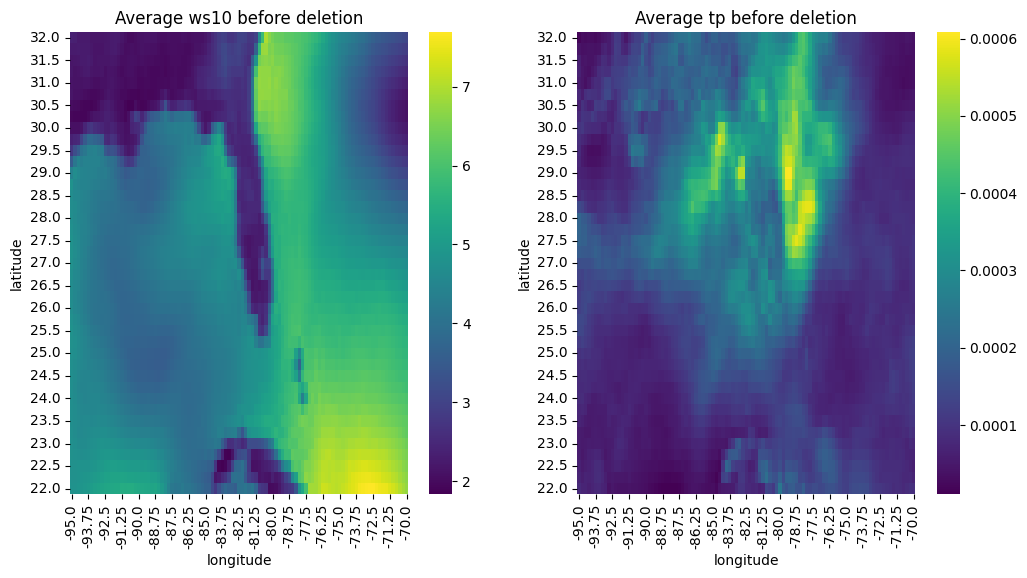

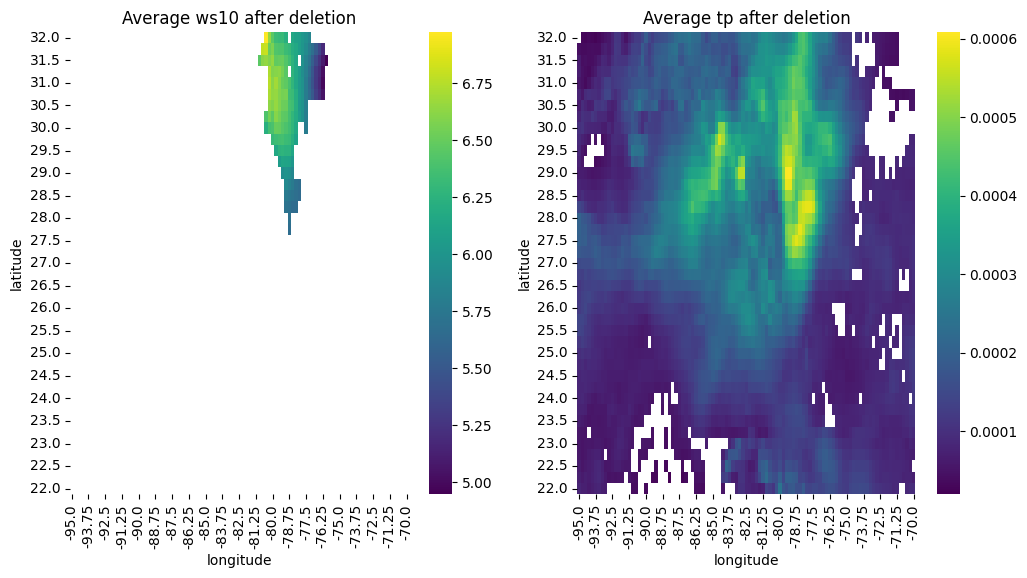

In [28]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 before deletion')

plt.subplot(122)
sns.heatmap(tp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
ws10_filtered = ws10_average.where(mask_ws10_average)
tp_filtered = tp_average.where(mask_tp_average)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

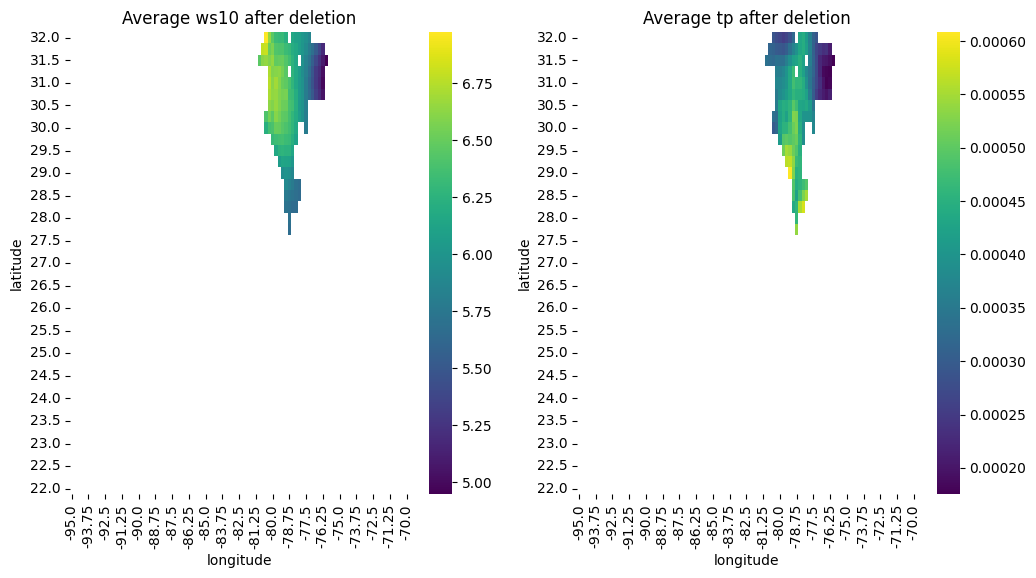

In [29]:
# Apply the mask and remove data from locations below thresholds
ws10_filtered_combined = ws10_average.where(combined_mask)
tp_filtered_combined = tp_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

In [30]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

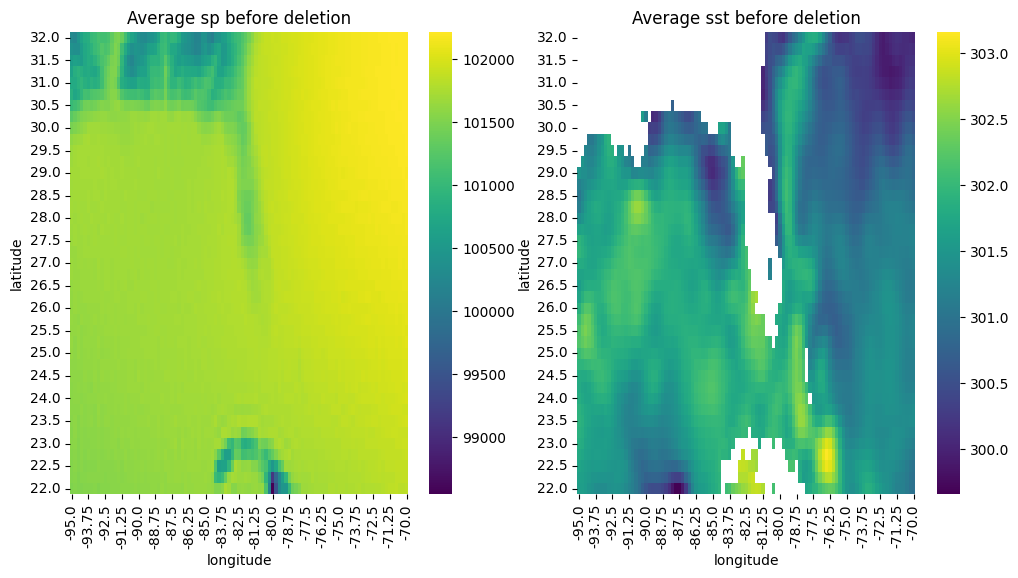

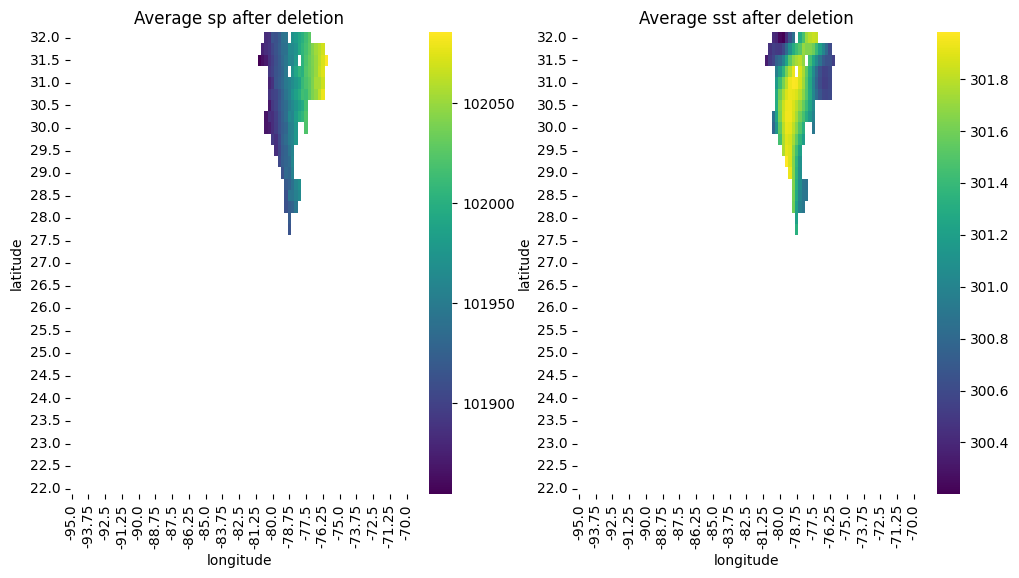

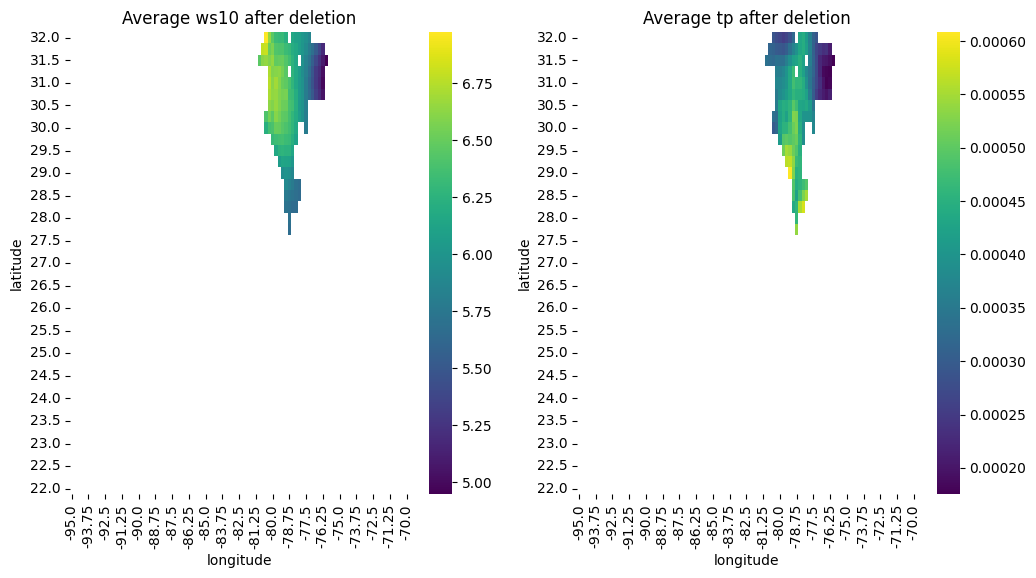

In [31]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp before deletion')

plt.subplot(122)
sns.heatmap(sst_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
sp_filtered = sp_average.where(combined_mask)
sst_filtered = sst_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp after deletion')

plt.subplot(122)
sns.heatmap(sst_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst after deletion')
plt.show()

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

Hurricane Abby was Cat 1. Lets analyse a more serious hurricane such as Michael in 2018 which was Cat 5.

EDA for Hurricane Michael.

In [19]:
speeds = xr.open_dataset("data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

Ignoring index file 'data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file 'data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file 'data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file


In [20]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [22]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [23]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [24]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [25]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [26]:
combined_mask = mask_ws10_average & mask_tp_average

In [27]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

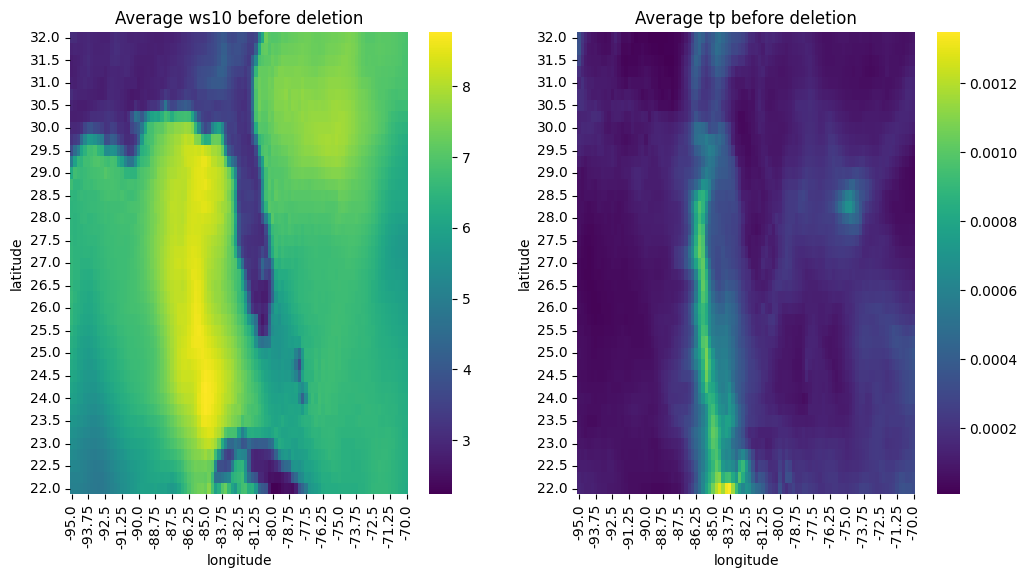

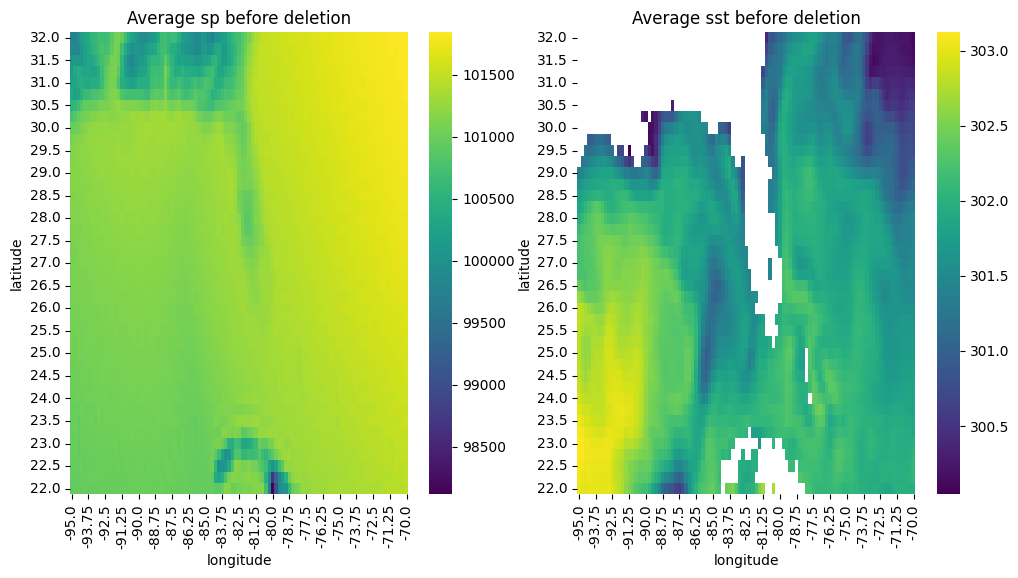

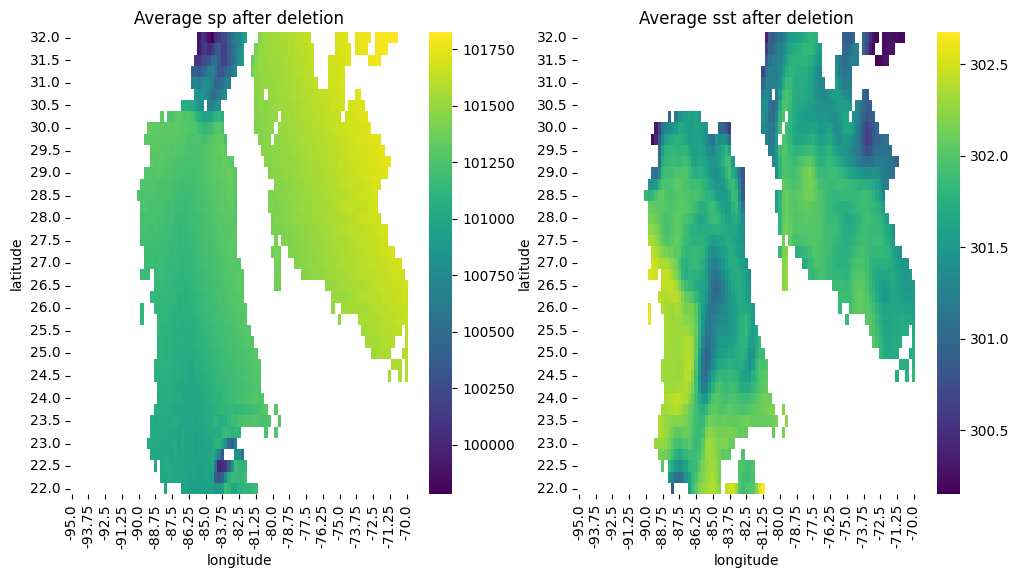

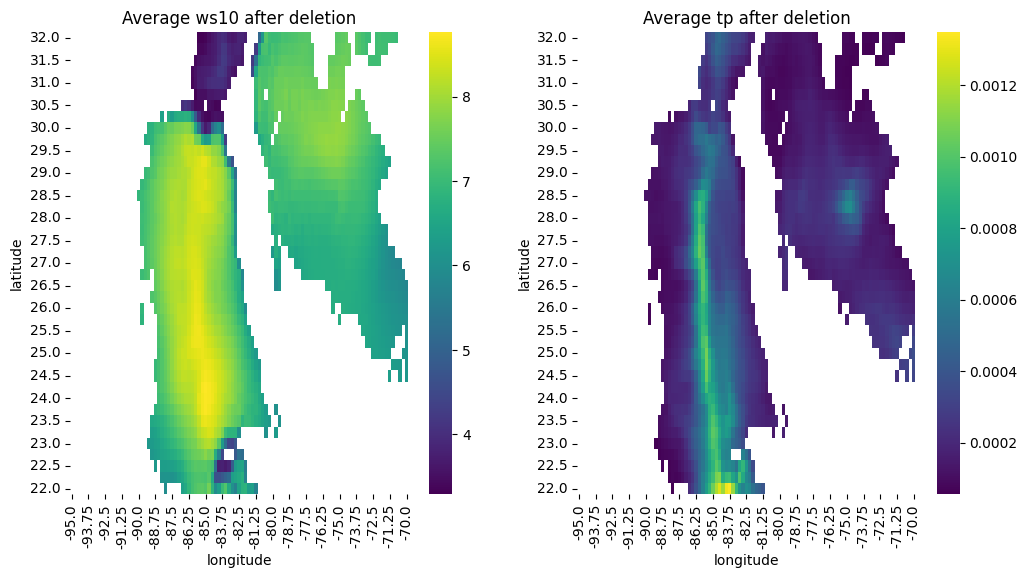

In [31]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 before deletion')

plt.subplot(122)
sns.heatmap(tp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp before deletion')
plt.show()

# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp before deletion')

plt.subplot(122)
sns.heatmap(sst_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
ws10_filtered_combined = ws10_average.where(combined_mask)
tp_filtered_combined = tp_average.where(combined_mask)
sp_filtered = sp_average.where(combined_mask)
sst_filtered = sst_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp after deletion')

plt.subplot(122)
sns.heatmap(sst_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst after deletion')
plt.show()

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

Much more area experiences an extreme weather event.

Correlation Plots

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [153]:
df_combined = pd.merge(speeds.ws10, rainfall, on=['time','latitude','longitude'], how='inner')
df_combined.drop(["number", "surface", "valid_time"], axis=1, inplace=True)

In [154]:
df_combined

ws10   tp
time                latitude longitude               
2018-10-06 06:00:00 32.0     -95.0      3.027605  0.0
                             -95.0      3.027605  0.0
                             -95.0      3.027605  0.0
                             -95.0      3.027605  0.0
                             -95.0      3.027605  0.0
...                                          ...  ...
2018-10-15 18:00:00 22.0     -70.0      8.187593  NaN
                             -70.0      8.187593  NaN
                             -70.0      8.187593  NaN
                             -70.0      8.187593  NaN
                             -70.0      8.187593  NaN

[993840 rows x 2 columns]

In [155]:
correlations = df_combined.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

In [156]:
correlations

latitude  longitude
22.0      -95.00       0.058171
          -94.75       0.051493
          -94.50       0.018326
          -94.25      -0.065140
          -94.00      -0.094340
                         ...   
32.0      -71.00       0.361354
          -70.75       0.368386
          -70.50       0.423019
          -70.25       0.443827
          -70.00       0.486607
Length: 4141, dtype: float64

In [157]:
temp = correlations.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

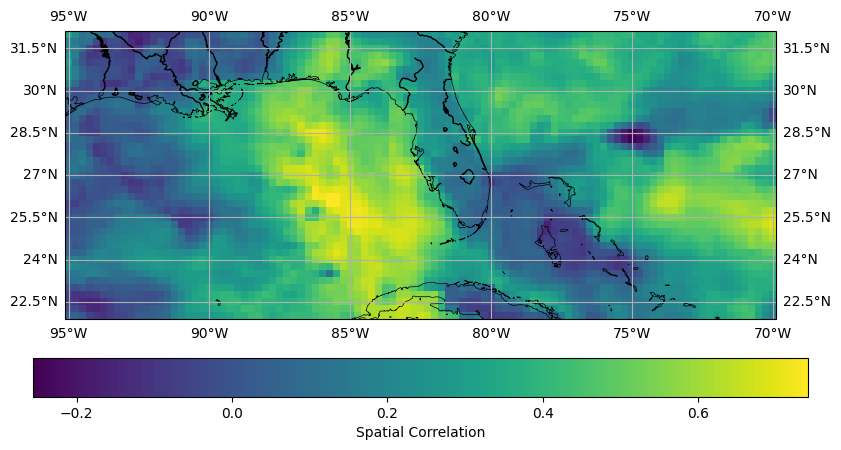

In [158]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);



In [159]:
correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

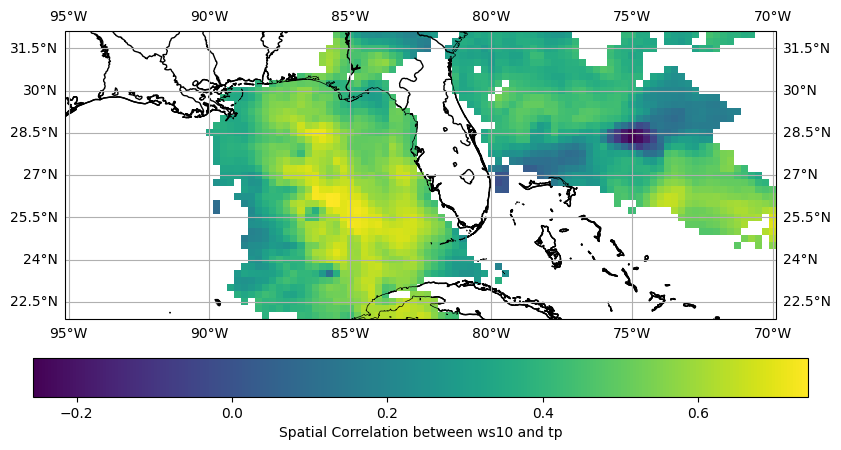

In [160]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [161]:
df_temp = pd.merge(df_combined, extra.sp, on=['time','latitude','longitude'], how='inner')
df_complete = pd.merge(df_temp, extra.sst, on=['time','latitude','longitude'], how='inner')

In [162]:
df_complete

ws10   tp          sp         sst
time                latitude longitude                                       
2018-10-06 06:00:00 32.0     -95.0      3.027605  0.0   99904.375         NaN
                             -95.0      3.027605  0.0   99904.375         NaN
                             -95.0      3.027605  0.0   99904.375         NaN
                             -95.0      3.027605  0.0   99904.375         NaN
                             -95.0      3.027605  0.0   99904.375         NaN
...                                          ...  ...         ...         ...
2018-10-15 18:00:00 22.0     -70.0      8.187593  NaN  101666.375  301.945312
                             -70.0      8.187593  NaN  101666.375  301.945312
                             -70.0      8.187593  NaN  101666.375  301.945312
                             -70.0      8.187593  NaN  101666.375  301.945312
                             -70.0      8.187593  NaN  101666.375  301.945312

[993840 rows x 4 columns]

In [166]:
def corr_plot(data):

    data_filtered = data.where(combined_mask)

    temp = data_filtered.unstack()
    lat = temp.index.values
    lon = temp.columns.values
    data_grid = temp.values

    fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

    #ax.set_extent([-70, -95, 32, 22])

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

    # Add a colorbar
    cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Spatial Correlation')

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Show the plot
    plt.show()

    ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12);

In [165]:
ws10_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['sp']))
ws10_sst_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['sst']))
tp_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['sp'].corr(x['tp']))
tp_sst_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['sst'].corr(x['tp']))

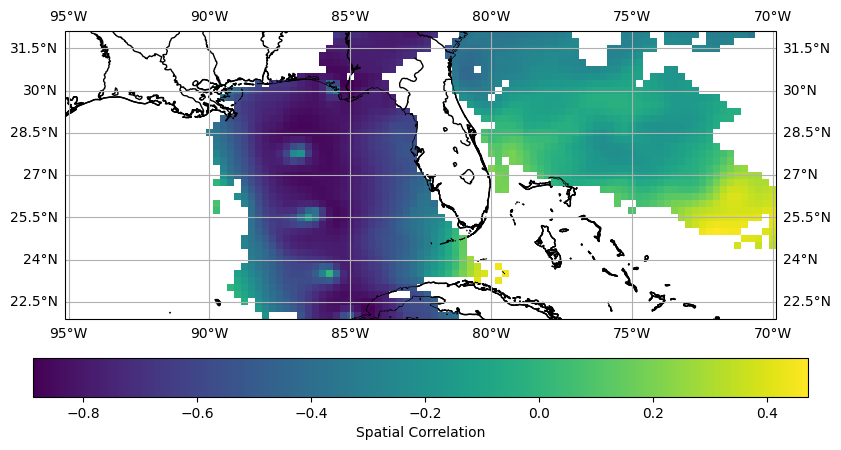

In [167]:
corr_plot(ws10_sp_corr)

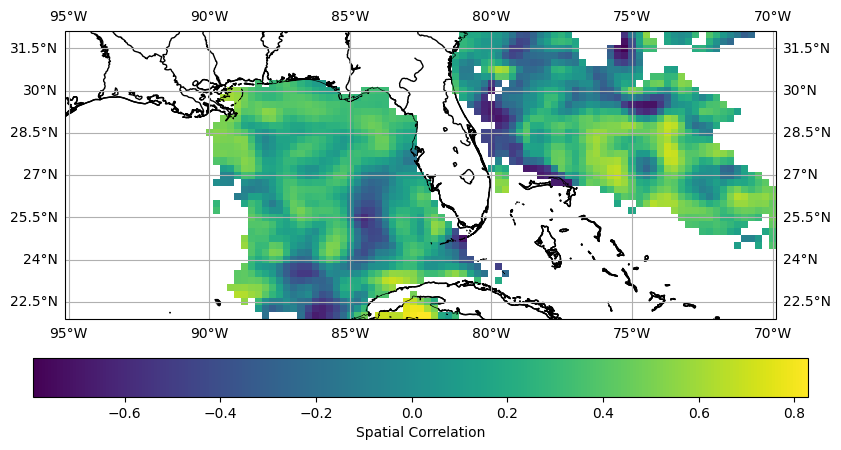

In [168]:
corr_plot(ws10_sst_corr)

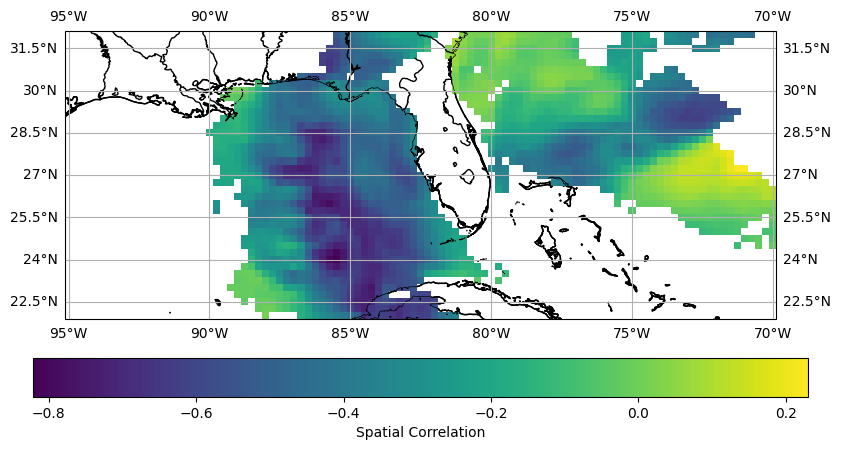

In [169]:
corr_plot(tp_sp_corr)

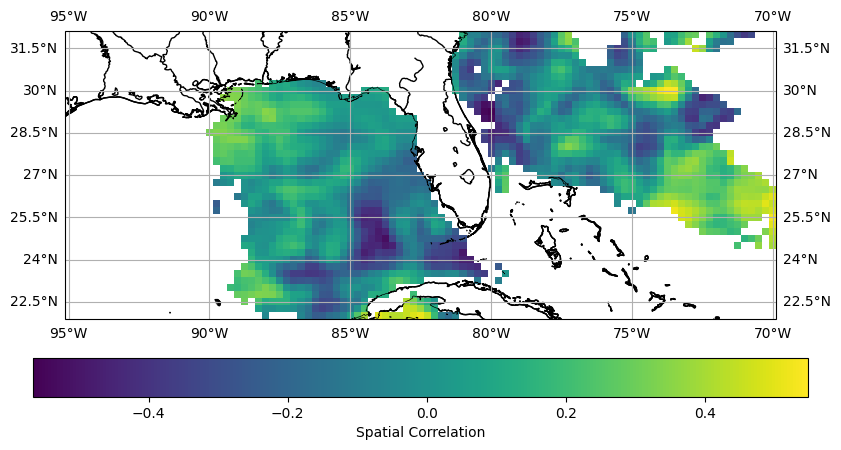

In [170]:
corr_plot(tp_sst_corr)